<h1>Описание проекта:</h1>

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

<h1>Цель проекта:</h1>

Выполнить работу по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет. Обучить модели, выбрать модель с лучшими значениями метрики AUC-ROC и дополнительной метрикой accuracy(значение должно быть не менее 0.85). Написать вывод.

<h1>Описание данных:</h1>

Данные состоят из файлов, полученных из разных источников:


- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.


Во всех файлах столбец customerID содержит код клиента.


Информация о договорах актуальна на 1 февраля 2020.

<h1>Содержание:</h1>

- Изучение файлов;
- Вопросы;
- План;
- Подготовка данных
- Анализ данных


In [1]:
!pip install scikit-learn==1.1.3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

RANDOM_STATE = 30423

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score


In [3]:
def analyze_data(df):
    rows_count, columns_count = df.shape
    print('Количество стобцов:', columns_count)
    print('Количество строк:', rows_count)
    display(df.head(5))
    display(df.describe())
    df.info()

In [4]:
df_contract = pd.read_csv('/datasets/contract_new.csv') 
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv') 
df_phone = pd.read_csv('/datasets/phone_new.csv') 

In [5]:
analyze_data(df_contract)

Количество стобцов: 8
Количество строк: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


<b>Выводы по датафрейму с информацией по договору:</b>

- В данных нет пропусков;
- Надо переименовать customerID в CustomerID;
- Столбец BeginDate и EndDate необходимо привести к формату "datetime";
- Столбец EndDate наш целевой признак, любая дата в этом поле соответствует оттоку клиента, если стоит значение "No" - клиент остался. После выделения целевого признака для значения "No" можно установить дату актуальности датасета - 2020-02-01.
- TotalCharges надо перевести в числовой тип;
- К PaymentMethod, Type и PaperlessBilling надо применить One Hot Encoding.

In [6]:
analyze_data(df_personal)

Количество стобцов: 5
Количество строк: 7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


<b>Выводы по датафрейму с персональными данными клиента:</b>

- В данных нет пропусков;
- Надо переименовать customerID в CustomerID и gender в Gender;
- К gender, Partner и Dependents надо применить One Hot Encoding.

In [7]:
analyze_data(df_internet)

Количество стобцов: 8
Количество строк: 5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2018-QKYGT,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


<b>Выводы по датафрейму с информацией об интернет-услугах:</b>

- В данных нет пропусков;
- Данные есть не по всем клиентам;
- Надо переименовать customerID в CustomerID;
- К InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies надо применить One Hot Encoding.

In [8]:
analyze_data(df_phone)

Количество стобцов: 2
Количество строк: 6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1658-XUHBX,No
freq,1,3390


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


<b>Выводы по датафрейму с информацией об услугах телефонии:</b>

- В данных нет пропусков;
- Данные есть не по всем клиентам;
- Надо переименовать customerID в CustomerID;
- К MultipleLines надо применить One Hot Encoding;

<h1>План</h1>

- Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные;
- Подготовить данных на основе выводов, полученных на предыдущем шаге;
- Провести исследовательский анализ данных - вузализация данных, избавление от выбросов;
- Перебор моделей и подбор их параметров;
- Вывод по итогам работы.

<h1>Подготовка данных</h1>

In [9]:
df_contract = df_contract.rename(columns={'customerID': 'CustomerID'})
print(df_contract.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [10]:
df_personal = df_personal.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
print(df_personal.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


In [11]:
df_internet = df_internet.rename(columns={'customerID': 'CustomerID'})
print(df_internet.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


In [12]:
df_phone = df_phone.rename(columns={'customerID': 'CustomerID'})
print(df_phone.columns.values)

['CustomerID' 'MultipleLines']


Привели сназвания столбцов к единому виду

In [13]:
df_contract['CO'] = (df_contract['EndDate'] != 'No').astype(int)
df_contract.head()

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CO
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0


Добавили новый столбец CO (customer outflow) с целевым признаком, который будет означать отказался клиент от услуг или нет.
При значении EndDate равном "No", клиент не ушел и целевой признак равен 0.
А при наличии даты ухода, целевой признак равен 1.

In [14]:
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'], ['2020-02-01'])
print(df_contract[df_contract['EndDate'] == 'No'].shape[0])

0


Поменяли "No" в столбце EndDate на дату актуальной информации датасета (01.02.2020)

In [15]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'], format='%Y-%m-%d')
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   CO                7043 non-null   int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(5)
memory usage: 495.3+ KB


Привели столбцы к фрмату даты

In [16]:
df_contract['AllDays'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days

Создали столбец с данными, сколько абонент пользовался услугами

In [17]:
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors ='coerce')
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   CO                7043 non-null   int64         
 9   AllDays           7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Привели к числовому виду, увидели наличие пропусков.

In [18]:
df_contract[df_contract['TotalCharges'].isnull()]

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CO,AllDays
488,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,NaN,0,0
753,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,NaN,0,0
936,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,NaN,0,0
1082,4367-NUYAO,2020-02-01,2020-02-01,Two year,No,Mailed check,25.75,NaN,0,0
1340,1371-DWPAZ,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.05,NaN,0,0
3331,7644-OMVMY,2020-02-01,2020-02-01,Two year,No,Mailed check,19.85,NaN,0,0
3826,3213-VVOLG,2020-02-01,2020-02-01,Two year,No,Mailed check,25.35,NaN,0,0
4380,2520-SGTTA,2020-02-01,2020-02-01,Two year,No,Mailed check,20.00,NaN,0,0
5218,2923-ARZLG,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.70,NaN,0,0
6670,4075-WKNIU,2020-02-01,2020-02-01,Two year,No,Mailed check,73.35,NaN,0,0


При изучении пропусков видно, что это абоненты, которые подключены в этот день. Можно пропуски заменить на 0.

In [19]:
df_contract['TotalCharges'] = df_contract['TotalCharges'].fillna(0)
df_contract['TotalCharges'].isnull().sum()

0

In [20]:
total_df = df_contract \
    .merge(df_personal, how='left', on='CustomerID') \
    .merge(df_internet, how='left', on='CustomerID') \
    .merge(df_phone, how='left', on='CustomerID')

Обьединим датафреймы в один

In [21]:
total_df['CustomerID'].is_unique


True

In [22]:
total_df = total_df.set_index('CustomerID')

Сделали CustomerID в качестве индекса

In [23]:
analyze_data(total_df)

Количество стобцов: 21
Количество строк: 7043


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,CO,AllDays,Gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,CO,AllDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,898.555729,0.162147
std,30.090047,2112.742814,0.363189,683.130510,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,276.000000,0.000000
50%,70.350000,1343.350000,0.000000,761.000000,0.000000
75%,89.850000,3236.690000,0.000000,1461.000000,0.000000
max,118.750000,9221.380000,1.000000,2314.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   CO                7043 non-null   int64         
 8   AllDays           7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

Видим пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines. Они скорее всего означают, что абонент не подключил услуги. Можно заменить пропуски на "No".

In [24]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    total_df[column] = total_df[column].fillna('No')

In [25]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   CO                7043 non-null   int64         
 8   AllDays           7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

Стало лучше

In [26]:
total_df['SeniorCitizen'] = total_df['SeniorCitizen'].astype('object')

In [27]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   CO                7043 non-null   int64         
 8   AllDays           7043 non-null   int64         
 9   Gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   object        
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity

<h1>Анализ данных</h1>

In [28]:
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

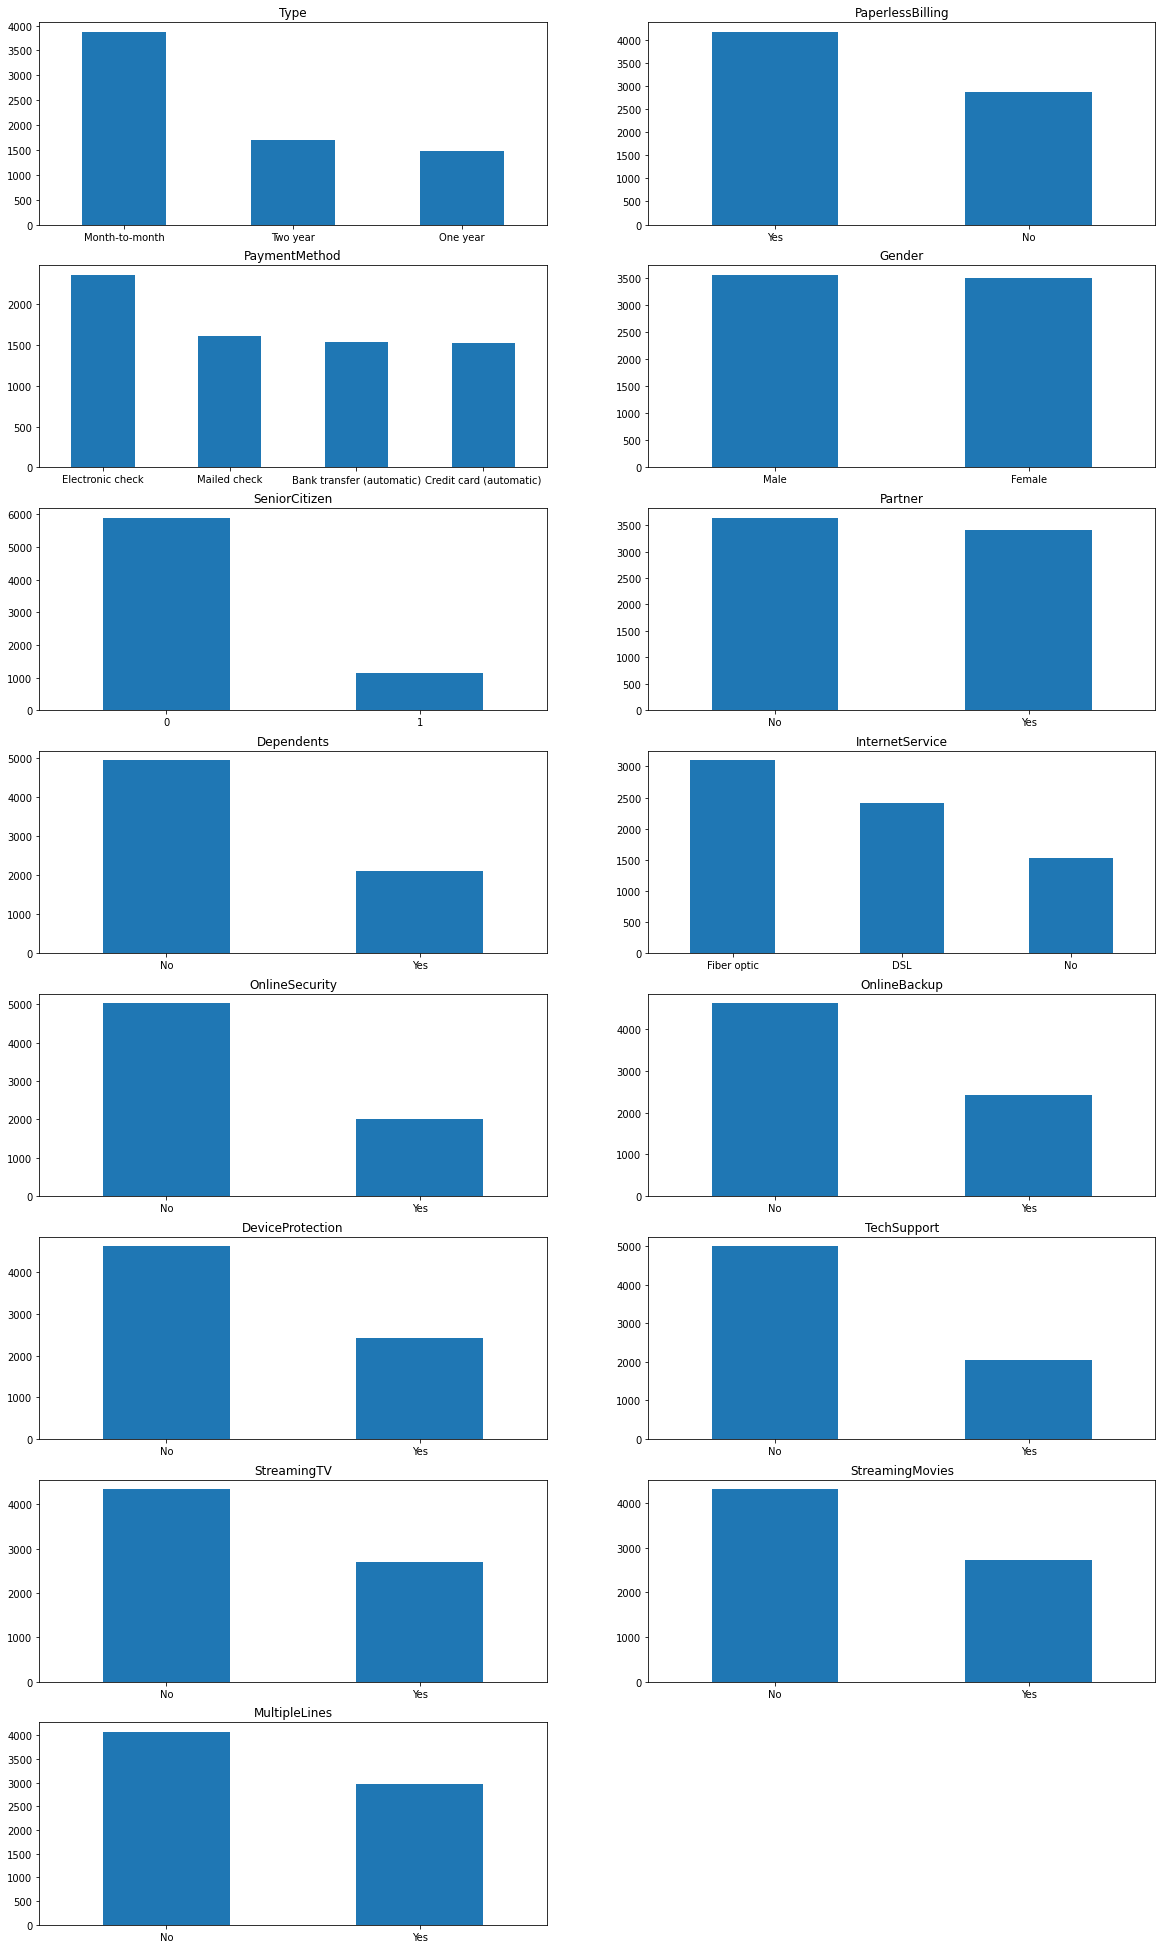

In [29]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 35))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    total_df[column].value_counts().plot(
        kind='bar', 
        title=column, 
        ax=ax,
        rot=0,
    )
        
plt.show()

Посмотрели распределение значений для категориальных данных

<b>Выводы:</b>

- Самый популярный способ оплаты - помесячный
- Люди чаще предпочитают получать счета в электронном виде и оплачивать их при помощи электронного чека
- Среди абонентов равное количество мужчин и женщин
- Пенсионеров немного
- Холстых\в браке примерно равное количество
- Иждевенцев у абонентов немного
- Самый частый способ подключения - оптоволокно
- Дополнительные услуги OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines не пользуются популярностью у пользователей

In [30]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'AllDays']

In [31]:
def plot_numerical(df):
    cols = 3
    rows = 2

    plt.figure(figsize=(15, 10))

    idx = 0
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.hist(df[column])
        plt.title(column)
    
    for column in numeric_columns:
        idx += 1 
    
        plt.subplot(rows, cols, idx)
        plt.boxplot(df[column])
        plt.title(column)
        
    plt.show()


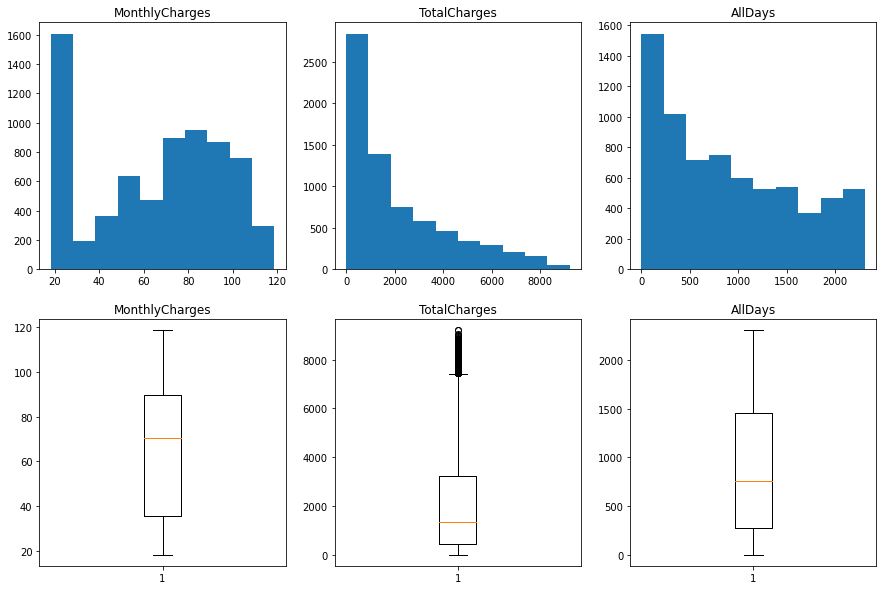

In [32]:
plot_numerical(total_df)

Выводы:

- Значения в столбце TotalCharges убывают, в то же время в столбце MonthlyCharges виден пик в райне 85 - это значит, что пользователи, которые платят за тариф много на долго не остаются
- Также у MonthlyCharges виден пик в районе 20, что является минимальным значением
- В столбце TotalDays видно 2 пика - в районе новых клиентов и лояльных, которые долго пользуются услугами
- Видны небольшие выбросы в потраченых деньгах на услуги. Скорее всего это люди, которые приобретают максимальные пакеты услуг.

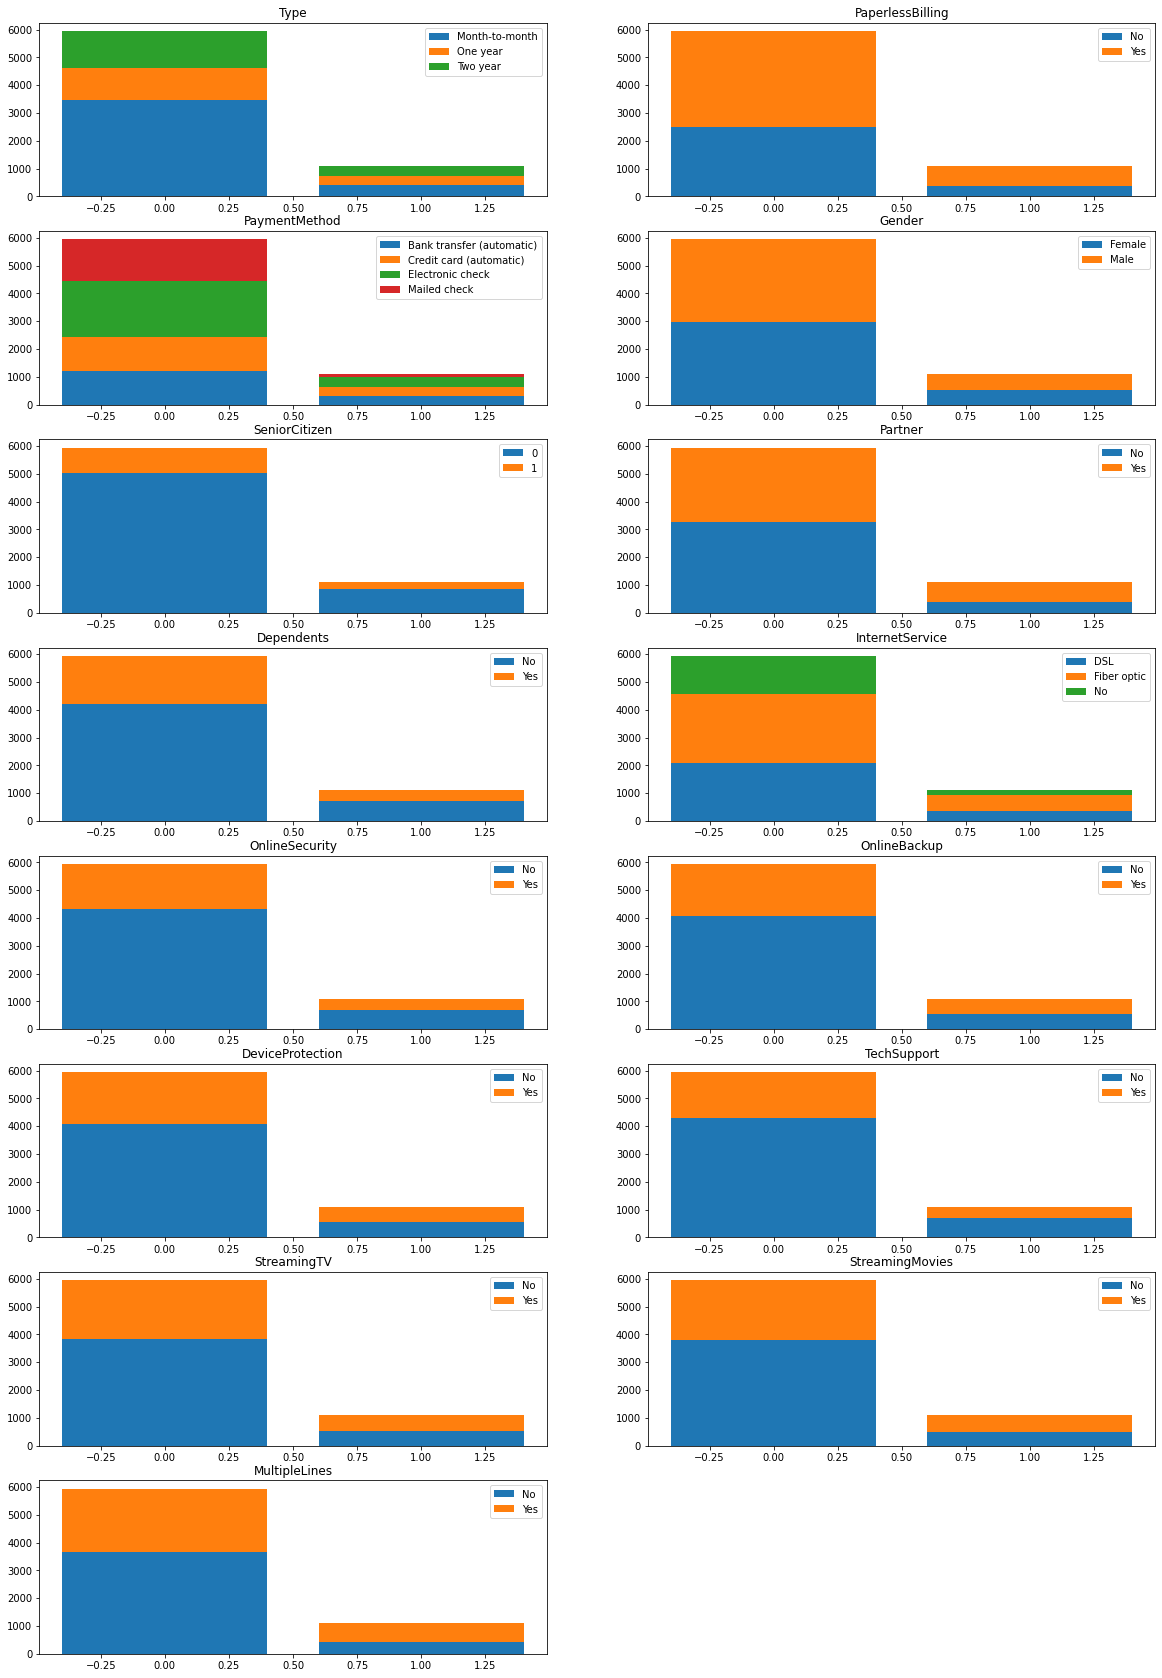

In [33]:
cols = 2
rows = int(np.ceil(len(categorial_columns) / cols))

plt.figure(figsize=(20, 30))

for idx, column in enumerate(categorial_columns):
    CO_grouped_df = total_df.groupby([column, 'CO'])['CO'].count()
    CO_grouped_df = CO_grouped_df.unstack()
    
    ax = plt.subplot(rows, cols, idx + 1)

    ax.bar(CO_grouped_df.T.index, CO_grouped_df.T[CO_grouped_df.T.columns[0]], label=CO_grouped_df.T.columns[0])
    bottom = np.array(CO_grouped_df.T[CO_grouped_df.T.columns[0]])
    for color_idx, value in enumerate(CO_grouped_df.T.columns[1:]): 
        ax.bar(CO_grouped_df.T.index, CO_grouped_df.T[value], bottom=bottom, label=value)
        bottom += np.array(CO_grouped_df.T[value])
    plt.title(column)
    plt.legend()
        
plt.show()

Посмотрев на распределение категорильных признаков относительно целевого признака пришли к выводам, что:
- Доля отказов среди тех, кто использует помесячную оплату выше, чем среди тех, кто сразу платит за 1/2 года
- Дополнительные услуги слабо влияют на отказы
- Пользователи использующие "Electronic check" для оплаты чаще отказываются от услуг, возможно в оплате онлайн есть какие-то неудобства
- Пенсионеры уходят чаще, но скорее всего не из-за качества услуг
- Если пользователь не пользуется интернетом, то вероятность отказа ниже. Скорее всего это связано с тем, что более возрастные люди не хотят разбираться в том, как сменить поставщика услуг

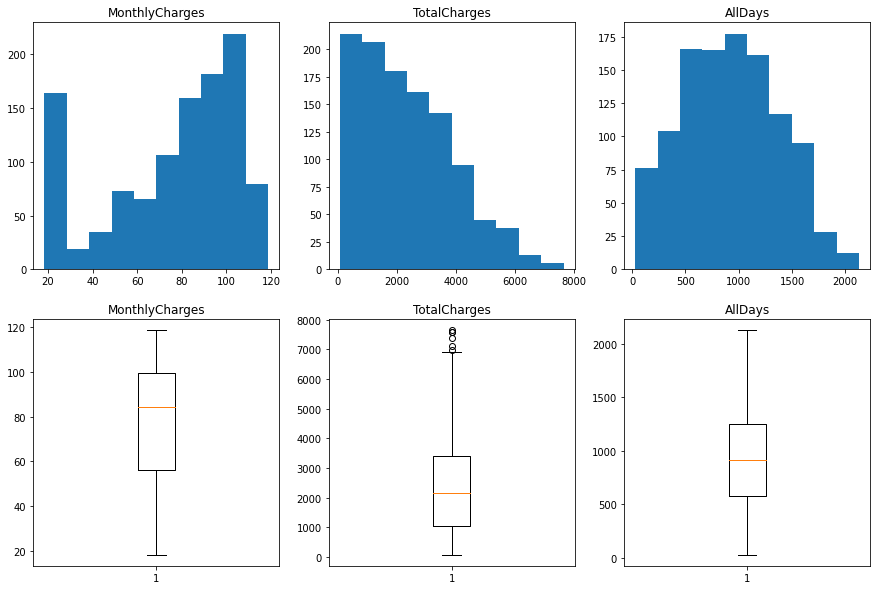

In [34]:
plot_numerical(total_df[total_df['CO'] == 1])

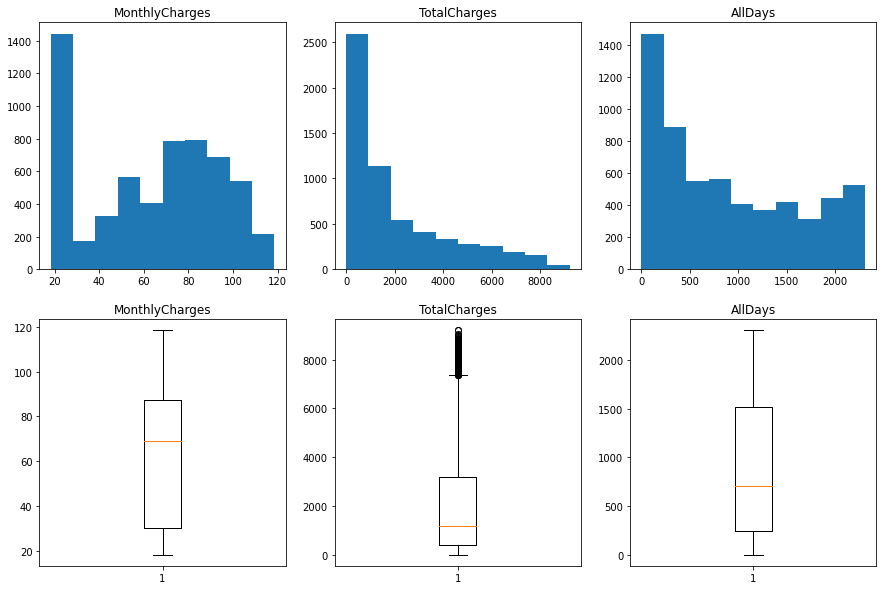

In [35]:
plot_numerical(total_df[total_df['CO'] == 0])

Посмотрев на распределение количественных признаков относительно целевого признака приходим к выводам:
- Со временем вероятность отказа от услуг снижается
- Обычно отказывались от услуг те, кто платил больше
- Текущие клиенты платят немного меньше в месяц, чем те, кто отказался

In [36]:
total_df[numeric_columns].corr()

,MonthlyCharges,TotalCharges,AllDays
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
AllDays,0.220054,0.821746,1.000000


У нас видна проблема мультиколлинеарности - корреляция между TotalCharges и TotalDays - 0.82, что логично - чем дольше клиент платит, тем больше итоговая сумма. Поле TotalCharges можем удалить.

In [37]:
del total_df['TotalCharges']
numeric_columns = ['MonthlyCharges', 'AllDays']

<h1>Подготовка данных для обучения</h1>

In [38]:
del total_df['BeginDate'], total_df['EndDate']

Удалили столбцы, они нам не нужны для обучения.

In [39]:
target = total_df['CO'] 
features = total_df.drop(columns=['CO'])

Разделим датасет на признаки и целевой признак

In [40]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=RANDOM_STATE)

Разделим датасет на выборки

In [41]:
tv=features_train.shape[0]/features.shape[0]
tt=target_test.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(tv))
print('Размер тестовой выборки - {:.0%}'.format(tt))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


In [43]:

ohe_features_ridge = features_train.select_dtypes(include='object').columns.to_list()
print(ohe_features_ridge)




['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [44]:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features

['MonthlyCharges', 'AllDays']

In [45]:
X_train_ridge = features_train.copy()
X_test_ridge = features_test.copy()

In [46]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

encoder_ohe.fit(X_train_ridge[ohe_features_ridge])

X_train_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_train_ridge[ohe_features_ridge])


X_train_ridge = X_train_ridge.drop(ohe_features_ridge, axis=1)


scaler = StandardScaler()


X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])


X_train_ridge.head()

,MonthlyCharges,AllDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,SeniorCitizen_1,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
6311-UEUME,0.479471,0.076298,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8908-NMQTX,0.035851,-0.771384,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2951-QOQTK,0.542845,-1.081226,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8051-HJRLT,0.200957,-1.081226,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7695-PKLCZ,-1.468454,1.721971,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:

X_test_ridge[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(X_test_ridge[ohe_features_ridge])

X_test_ridge = X_test_ridge.drop(ohe_features_ridge, axis=1)


X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)

X_test_ridge.head()

,MonthlyCharges,AllDays,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Gender_Male,SeniorCitizen_1,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
CustomerID,,,,,,,,,,,,,,,,,,,,,
4660-IRIBM,0.779665,-0.502464,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6994-ORCWG,-0.342727,-0.680770,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6834-NXDCA,-1.355047,-0.636924,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2979-SXESE,0.996471,-1.259532,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
0812-WUPTB,0.210964,-1.125072,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h1>Обучение моделей</h1>

In [48]:
def plot_roc_curve(target_train, predictions):
        
    fpr, tpr, thresholds = roc_curve(target_train, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

Функция для графического отображения AUC-ROC

<h1>RandomForestClassifier</h1>

In [49]:
param_grid = {
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 10],
    'n_estimators': [10, 50, 100], 
}

model = RandomForestClassifier(random_state=RANDOM_STATE)

search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search.fit(X_train_ridge, target_train)

print(search.best_params_)
print('ROC-AUC score:', search.best_score_)

predicted_probalities = search.best_estimator_.predict_proba(X_train_ridge)[:, 1]

{'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC score: 0.8166460891017359


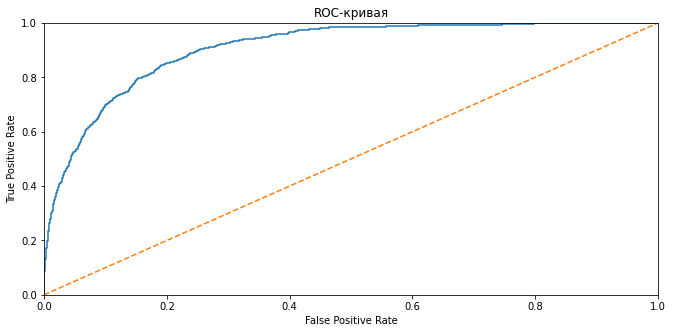

In [50]:
plot_roc_curve(target_train, predicted_probalities)

<h1>CatBoostClassifier</h1>

In [51]:
param_grid = {
    'learning_rate': [0.1, 0.3],
    'iterations': [50, 100],
    'l2_leaf_reg': [3, 9]
}

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

search_с = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search_с.fit(X_train_ridge, target_train)

print(search_с.best_params_)
print('ROC-AUC score:',search_с.best_score_)

predicted_probalities = search_с.best_estimator_.predict_proba(X_train_ridge)[:, 1]

{'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.3}
ROC-AUC score: 0.8888764435755607


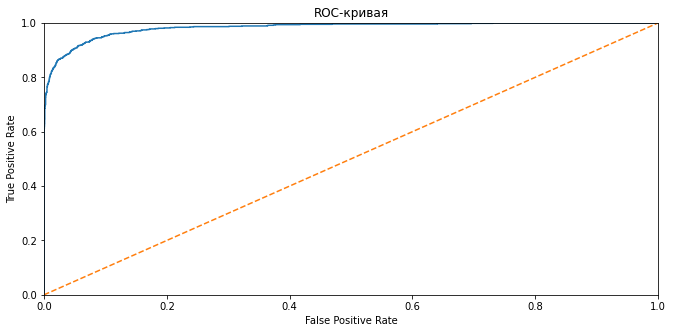

In [52]:
plot_roc_curve(target_train, predicted_probalities)

<h1>DecisionTreeClassifier</h1>

In [53]:
param_grid = {'max_depth' : [5, 6, 7, 8, 9]     
        }
        

model = DecisionTreeClassifier(random_state=RANDOM_STATE)

search_d = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
search_d.fit(X_train_ridge, target_train)

print(search_d.best_params_)
print('ROC-AUC score:',search_d.best_score_)

predicted_probalities = search_d.best_estimator_.predict_proba(X_train_ridge)[:, 1]


{'max_depth': 6}
ROC-AUC score: 0.7819663059613375


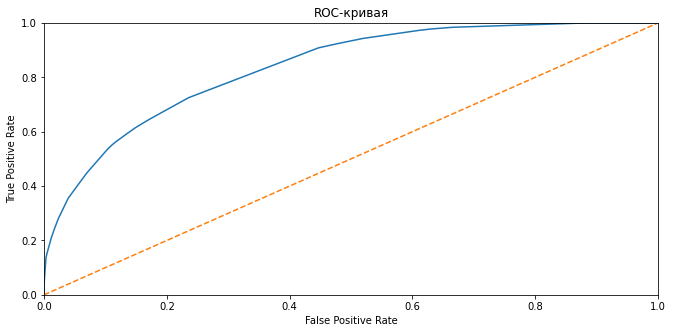

In [54]:
plot_roc_curve(target_train, predicted_probalities)

Лучший показатель у CatBoostClassifier, он равен 0.89

<h1>Проверка CatBoostClassifier на метрике Accuracy и тестовой выборке</h1>

In [55]:
def plot_roc_curve_test(X_test_ridge, predictions):
        
    print('ROC-AUC score', roc_auc_score(X_test_ridge, predictions))
    
    fpr, tpr, thresholds = roc_curve(X_test_ridge, predictions)

    plt.figure(figsize=(11, 5))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()
    
    

In [56]:

model = CatBoostClassifier(random_state=RANDOM_STATE, iterations=100, l2_leaf_reg=3, learning_rate=0.3, verbose=0)


model.fit(X_train_ridge, target_train)





predicted_probalities = model.predict_proba(X_test_ridge)[:, 1]
predictions_test = model.predict(X_test_ridge)





ROC-AUC score 0.9179933928789918


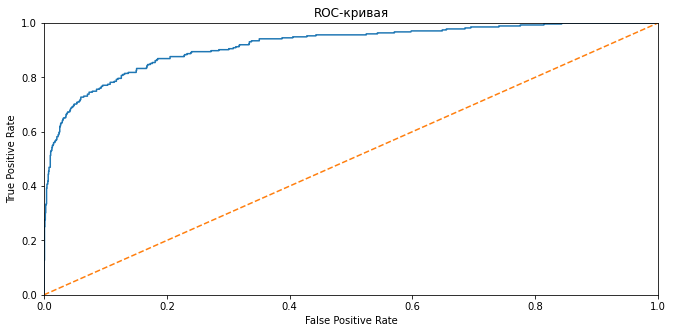

In [57]:
plot_roc_curve_test(target_test, predicted_probalities)

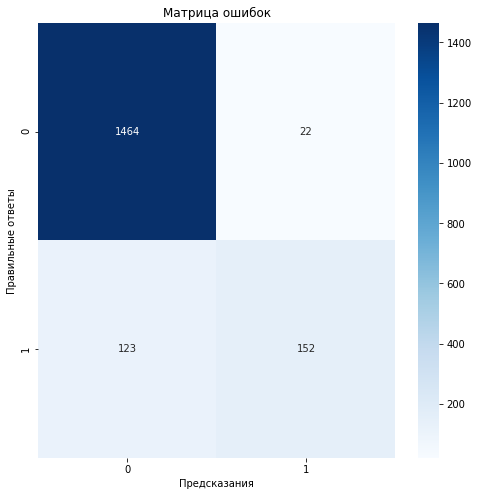

In [58]:
cmatrix = confusion_matrix(target_test, predictions_test)
plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, 
                annot=True,  
                cmap='Blues', 
                fmt='d').set(title='Матрица ошибок', xlabel='Предсказания', ylabel='Правильные ответы')
plt.show();

In [59]:
train_dataset = Pool(X_train_ridge, target_train)

In [61]:
feature_importance = search_с.best_estimator_.get_feature_importance(train_dataset, prettified = True)

In [62]:
feature_importance

,Feature Id,Importances
0,AllDays,49.481421
1,MonthlyCharges,10.823882
2,Type_Two year,4.801426
3,Partner_Yes,4.011144
4,MultipleLines_Yes,3.487647
5,OnlineBackup_Yes,2.921427
6,Type_One year,2.787313
7,PaymentMethod_Mailed check,2.709159
8,DeviceProtection_Yes,2.602148
9,StreamingMovies_Yes,2.271890


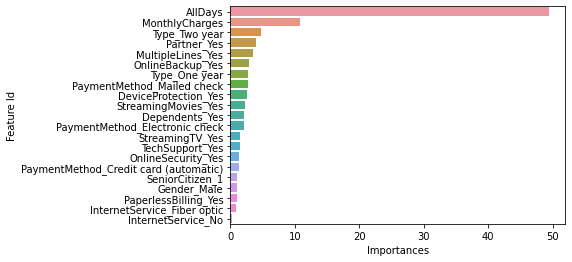

In [63]:
sns.barplot(y=feature_importance['Feature Id'], x=feature_importance['Importances']);

Достаточно логично, что на лояльность клиентов виляет время использования услуг. Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Второй и третий признак - месячные траты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.

<h1> Выводы</h1>

- В данной работе проведена работа по предсказанию того, откажется ли клиент от услуг оператора сотовой связи или нет
- Сначала данные были прочитаны и по ним были сделаны предварительные выводы
- После этого была произведена первичная обработка данных - переименованы столбцы, изменены типы данных
- Были добавлены 2 новых столбца - целевой признак CO (customer outflow), который означает отказался ли клиент от услуг и AllDays, который обозначает сколько по времени пользователь пользовался услугами
- После этого был проведен исследовательский анализ данных - проанализированы количественные и категоральные признаки, проведена попытка найти связь между ними и целевым признаком
- Были сделаны следующие выводы: со временем вероятность отказа от услуг снижается и обычно отказывались от услуг те, кто платил больше
- После этого была проведена подготовка данных к обучению моделей: удалены ненужные столбцы, применена техника OHE, датафрейм был разделен на обучающую и тестовую выборки, проведено масштабирование количественных признаков и проведен upsample
- Затем на данных были обучены 3 модели: DecisionTreeClassifier, RandomForestClassifier и CatBoostClassifier
- Лучший результат показала модель CatBoostClassifier со значением метрики ROC-AUC в 0.0.891, что выше, чем значение, требуемое в задании
- Самые важные факторы - сколько клиент пользуется услугами и сколько он платит в месяц

<h1>Общие выводы</h1>

При выполнении работы были загружены и рассмотрены таблицы с данными:

- df_contract;
- df_internet;
- df_personal;
- df_phone.

I. Исследовательская часть

Всего в выборке представлены договоры с 7043 клиентами, из которых пользователей интернета - 5517, пользователей телефона - 6361. Явные пропуски и дубликаты не найдены.

В процессе были решены проблемы для предобработки данных:

- Привели названия столбцов к единому виду

- Добавили новый столбец CO (customer outflow) с целевым признаком, который будет означать отказался клиент от услуг или нет. При значении EndDate равном "No", клиент не ушел и целевой признак равен 0. А при наличии даты ухода, целевой признак равен 1.


- BeginDate – поле приведено к типу datetime;

- EndDate – для значений "No" установлена "заглушка", соответствующая дате актуальности датасета - 2020-02-01), после чего поле было приведено к формату datetime;

- Создали столбец с данными, сколько абонент пользовался услугами

- В столбце TotalCharges - неявные пропуски (пустые значения) заменены 0, так как пропуски маркеруют клиентов, начавших пользоваться услагми компании в феврале 2020 года.

После чего все датафреймы были объединены.

Из статистических характеристик объедененного датафрейма можно выделить интересные особенности:

- Практически две трети пользователей предпочитают безналичный расчет;

- Среднее значение месячных трат практически совпадает с медианным значением, то есть имеет распределение с небольшим отрицательным смещением;

- Распределение значений суммарных трат наоборот, сильное положительное смещение - медиана практически на 40% меньше среднего. Возможно это связано с наличием нулей - неявных пропусков. Это нужно выяснить далее;

- Относительно демографии: 16% пенсионеров, 48% имеют супруга(у), у 29% клиентов имеются иждевенцы. Баланс классов гендера соблюдается;

- 34% пользователей продолжают использовать интернет соединение через через телефонную линию, 42% пользователей имеют возможность использовать вторую линию во время звонка;

Было исследовано распределение даты регистрации клиентов во времени: наблюдается пик в начале 2014 года, что связано с началом работы компании. С начала 2015 по конец 2018 года - величина вновь привлеченных клиентов стабильна. Далее с начала 2019 по начало 2020 года снова наблюдаем бурный рост количества новых клиентов.

На протяжении 4 месяцев подряд происходил равномерный отток клиентов (октябрь 2019 - январь 2020).

Среди оттекших клиентов есть представители каждой из выделенной ранее групп. Примечательно, что оттекшие клиенты пользовались в основном дорогими тарифами.

Средняя длительность пользования услугами у оттекших клиентов практически в два раза меньше, чем у тех, которые остались.

Данные были Разбиты на 2 выборки в соотношении 75:25. Проведено кодирование и масштабирование.

II. Модельная часть

Было выбрано три модели:
- RandomForestClassifier
- CatBoostClassifier
- DecisionTreeClassifier

Лучше всего на выбранной метрике ROC-AUC, равной 0,88, что выше установленного минимума показала себя модель CatBoostClassifier c следующими параметрами: random_state=30423, iterations=100, l2_leaf_reg=3, learning_rate=0.3, verbose=0.
При данных параметрах ROC-кривая на графике выглядит так:
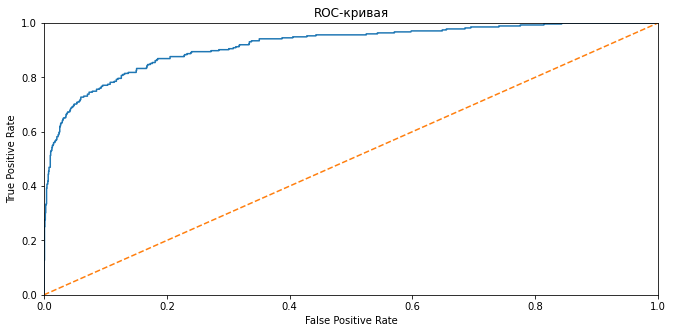

А Матрица ошибок так:
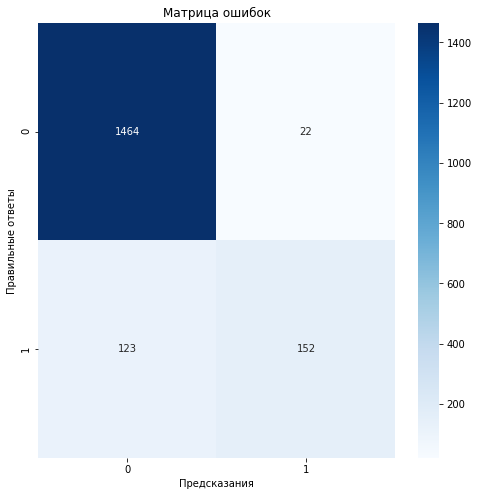


Остальные модели не показали, установленного в 0,85, минимумуа выбранной метрики 

На тестовой выборке модель CatBoostClassifier показала значение метрики, равное 0,91, что подверждает достаточный уровень.

III. Анализ важности признаков модели

Признаки, оказывающие на модель влияние:
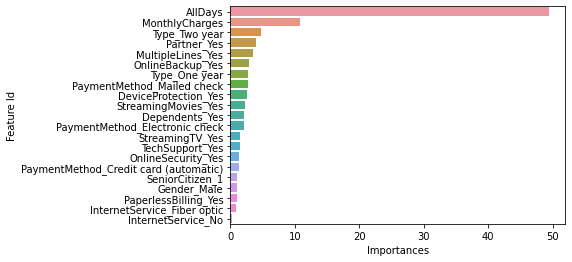

Достаточно логично, что на лояльность клиентов виляет время использования услуг. Как правило, чем дольше ты пользуешься услугами компании, тем меньше вероятность что ты от туда уйдешь. Второй и третий признак - месячные траты, тоже достаточно логично, учитывая исследовательский анализ данных проведенных ранее. Затем идут признаки, отвечающие за срок договора, гендер и т.д.

План на данную работу был следующий:
- Изучить данные в файлах - проверить типы, есть ли пропуски, надо ли преобразовывать данные;
- Подготовить данных на основе выводов, полученных на предыдущем шаге;
- Провести исследовательский анализ данных - вузализация данных, избавление от выбросов;
- Перебор моделей и подбор их параметров;
- Вывод по итогам работы.

Все пункты плана были выполнины и получен результат, превосходящий минимальный, что является хорошим итогом работы.
Во время работы возикли сложности с кодированием данных, так как не сразу удалось сообразить, что для корректного выполнения выбранного кода, необходимо было обновить библиотеку scikit-learn до версии 1.1.3
